# Using a Deep RL Methodology, train a model to solve the Luner_Lander problem.


# Step1. Install AI Gym, the instructions can be found at OpenAI-Lunar-Lander(https://www.gymlibrary.dev/environments/box2d/lunar_lander/) Links to an external site.

In [1]:
# ! pip install gymnasium
# ! pip install box2d pygame

In [2]:
import gymnasium as gym 
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

# Step2. Import the environment

In [3]:
env = gym.make("LunarLander-v2", render_mode="human")
# env.close()
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<LunarLander<LunarLander-v2>>>>>

In [4]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Device - {device}")
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


Device - mps


# Step3. Train a model

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [8]:
BATCH_SIZE = 128   # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99       # GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.9    # EPS_START is the starting value of epsilon
EPS_END = 0.005     # EPS_END is the final value of epsilon
EPS_DECAY = 1000   # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005        # TAU is the update rate of the target network
LR = 1e-3          # LR is the learning rate of the ``AdamW`` optimizer


n_actions = env.action_space.n  # Get number of actions from gym action space
state, info = env.reset()       # Get the number of state observations
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory    = ReplayMemory(10000)

In [9]:
steps_done = 0


def select_action(state):
    """
    t.max(1) will return the largest column value of each row.
    second column on max result is index of where max element was
    found, so we pick action with the larger expected reward.
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


In [10]:
def plot_durations(episode_durations, episode_rewards = [], show_result=False):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot episode durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        axs[0].set_title('Result')
    else:
        axs[0].clear()
        axs[0].set_title('Training...')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Duration')
    axs[0].plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axs[0].plot(means.numpy())

    # Plot episode rewards
    if episode_rewards:
        axs[1].set_title('Episode Rewards')
        axs[1].set_xlabel('Episode')
        axs[1].set_ylabel('Reward')
        axs[1].plot(episode_rewards)

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [11]:
def optimize_model():
    """
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    """
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))

    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


<Figure size 640x480 with 0 Axes>

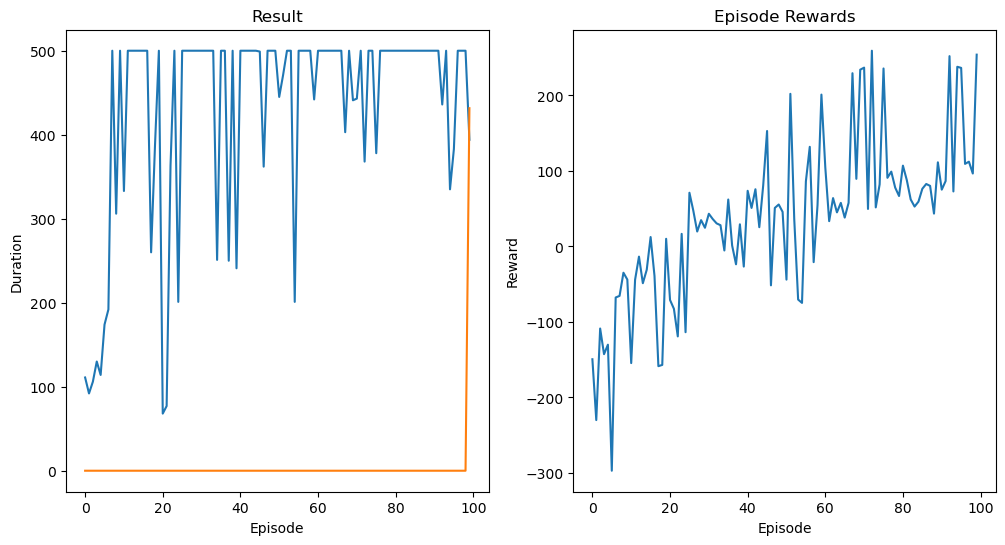

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
import numpy as np

num_episodes = 500 if torch.cuda.is_available() else 100
episode_durations = []
episode_rewards = []

for i_episode in range(num_episodes):

    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    episode_reward = []
    for t in range(500):
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([np.float64(reward).astype(np.float32)], device=device)
        done = terminated or truncated

        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        
        memory.push(state, action, next_state, reward) # Store the transition in memory

        state = next_state # Move to the next state

        optimize_model() # Perform one step of the optimization (on the policy network)


        # Soft update of the target network's weights,  θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        episode_reward.append(reward.item())
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(sum(episode_reward))
            plot_durations(episode_durations, episode_rewards)
            break
            
    if not done:
        episode_durations.append(t + 1)
        episode_rewards.append(sum(episode_reward))
        plot_durations(episode_durations, episode_rewards)
    
print('Complete')
plot_durations(episode_durations, episode_rewards, show_result=True)
plt.ioff()
plt.show()

# Step4. Discuss the parameters used to produce your training results

In [13]:
BATCH_SIZE = 128    # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99       # GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.9    # EPS_START is the starting value of epsilon
EPS_END = 0.05     # EPS_END is the final value of epsilon
EPS_DECAY = 1000   # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005        # TAU is the update rate of the target network
LR = 1e-3          # LR is the learning rate of the ``AdamW`` optimizer

## BATCH_SIZE: 
In this training Batch size is a hyperparameter which defines the number of steps performed in one iteration during training. Higher the number higher compute will be required for model to compile the steps. But higher number will make it more good learner, which will result in smoother learning curves. Smaller batch sizes can introduce more variations into the learning process but the model convergence will be very slow. As we can see in the above plots, its very noisy curves generated by the batch size of 64.


## GAMMA (Discount Factor): 
It controls the imapct of upcoming rewards in the next decision-making. Its value are in range of (0 to 1), 0 means near thinking but not optimizing the long term goal, bu the value closer to 1 keep the long term goal in consideration.


## TAU (Target Network Update Rate): 
Tau is a smoothness factor for the model updates. Lower the value of Tau means, model will do the faster updates and higher the value model will adjust slowly for the updates.


## EPS_START 
itrepresents the initial exploration rate, determining the probability of choosing a random action at the beginning of training. 

## EPS_END 
It represents the minimum exploration rate, ensuring that the agent gradually transitions from exploration to exploitation as training progresses. 

## EPS_DECAY 
It controls the rate of decay of epsilon over time, influencing the balance between exploration and exploitation throughout training.

These 3 above parameters are used in the reinforcement learning to balance exploration and exploitation.

## LEARNING RATE (LR): 
In any of the Machine Learning algorithm, learning rate is one of key hyper parameter which controls how the model will update its weight. A higher learning rate can poses the issue of the gradient overshooting, and lowe learning rate can lead to the slower convergence which will require a lot of compute power and algorithm can get stuck at local minima. Here I use the learning rate of 0.001, I tried 0.0001, but it was not working well.




# Step5. Play an episode of the problem using your agent.

In [22]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

total_reward = 0
for t in range(2000):
    action = select_action(state)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([np.float64(reward).astype(np.float32)], device=device)
    done = terminated or truncated
    total_reward += reward.item()
    if t%50 ==0 : print(f"{t = }, {reward.item() = }, {terminated = }, {truncated = }")
    next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    memory.push(state, action, next_state, reward)
    state = next_state
    if done:
        print(f"Completed with {terminated = }, {truncated = }")
        break

t = 0, reward.item() = 0.06722377985715866, terminated = False, truncated = False
t = 50, reward.item() = -1.7438669204711914, terminated = False, truncated = False
t = 100, reward.item() = 3.944681167602539, terminated = False, truncated = False
t = 150, reward.item() = -1.1435314416885376, terminated = False, truncated = False
t = 200, reward.item() = -2.263540029525757, terminated = False, truncated = False
t = 250, reward.item() = -2.5700156688690186, terminated = False, truncated = False
Completed with terminated = True, truncated = False


### Here is the successfull landing of the module

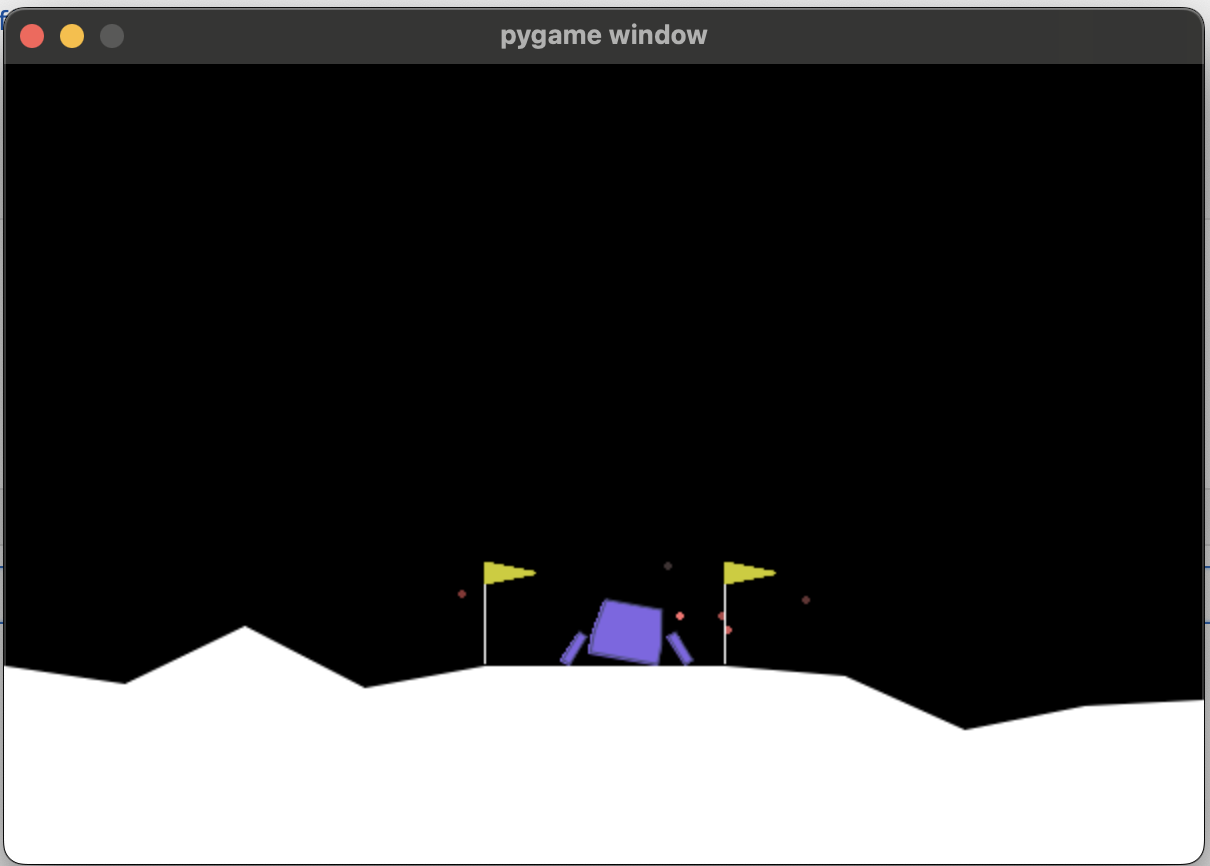

# Step6. Discuss the results in terms of success rate

## Observations - 

* Here we can see from the plots that model is learning. we can see the continuous increase in the reward values.

* I am using the lower batch size, as I have lower compute power available and with 500 steps, I dont want to wait till 128 or 256 steps before model can start learning.

* Given the more training, model will learn and shows a great success.

* One problem I noticed in my training we can see that a lot of time it touches the maximum duration, which shows that the lunar module did not land and it just dangled in the air, which resulted in the bad learning.

* I explored the lower elarning rate of 0.0001 which resulted in after a certain point lunar module never landed, it was just hover over.